# Compare Auxtel Fitted Spectra and comparison with Merra2

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-01-16
- last update : 2024-01-16
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
#%matplotlib widget 
import h5py
from scipy import interpolate
from astropy.time import Time

In [2]:
import matplotlib.ticker
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

# Read pandas Series

In [4]:
!ls Data_Auxtel_Spectro/

out_allfittedparams_2021.csv  spec_series_repo_embargo.csv
out_allfittedparams_2022.csv  spec_series_repo_main.csv
out_allfittedparams_2023.csv


In [5]:
files = [ "Data_Auxtel_Spectro/out_allfittedparams_2021.csv", 
          "Data_Auxtel_Spectro/out_allfittedparams_2022.csv",
          "Data_Auxtel_Spectro/out_allfittedparams_2023.csv"
        ]
N = len(files)

In [6]:
all_df = [pd.read_csv(files[idx], index_col=0, header=0) for idx in range(N)]

In [7]:
df = pd.concat(all_df)

In [8]:
df.head()

,DATE-OBS,id,BITPIX,NAXIS,NAXIS1,NAXIS2,EXTEND,TARGET,REDSHIFT,GRATING,...,PWV [mm]_y,PWV [mm]_err_y,reso [pix],reso [pix]_err,D_CCD [mm]_y,D_CCD [mm]_err_y,alpha_pix [pix],alpha_pix [pix]_err,B_y,B_err_y
0,2021-02-19 06:06:21.680773316+00:00,2021021800567,-64,2,1026,3,True,HD 60753,0.000065,holo4_003,...,3.218831,0.041076,1.248581,0.032250,179.908783,0.005335,0.919528,0.0,0.0,0.0
1,2021-02-19 06:06:39.653513123+00:00,2021021800568,-64,2,1026,3,True,HD 60753,0.000065,holo4_003,...,4.892852,0.065769,1.010320,0.040263,180.103640,0.005326,1.032621,0.0,0.0,0.0
2,2021-02-19 06:09:14.981344845+00:00,2021021800571,-64,2,1026,3,True,HD 60753,0.000065,holo4_003,...,2.774251,0.056648,1.041415,0.034725,180.108969,0.006287,0.719562,0.0,0.0,0.0
3,2021-02-19 06:11:17.065814394+00:00,2021021800572,-64,2,1026,3,True,HD 60753,0.000065,holo4_003,...,4.908347,0.065531,1.019116,0.025627,179.995195,0.005110,1.014450,0.0,0.0,0.0
4,2021-02-19 06:12:45.478077809+00:00,2021021800574,-64,2,1026,3,True,HD 60753,0.000065,holo4_003,...,4.619187,0.077716,1.135575,0.028598,180.236999,0.005797,0.256973,0.0,0.0,0.0


In [9]:
cut = df["FILTER"] == "empty"
df = df[cut]

In [10]:
# convert pandas to numpy rec array
rec = df.to_records()

In [11]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

3178
3033
2921
2665
2601
1524


In [12]:
stars = np.unique(rec["TARGET"])
stars

array(['18 Sco', '18Sco', 'BD-113759', 'Feige110', 'HD 009051',
       'HD 031128', 'HD 111980', 'HD 14943', 'HD 160617', 'HD 167060',
       'HD 185975', 'HD 200654', 'HD 2811', 'HD 38666', 'HD 38949',
       'HD 42525', 'HD 60753', 'HD009051', 'HD031128', 'HD074000',
       'HD111980', 'HD115169', 'HD142331', 'HD146233', 'HD14943',
       'HD160617', 'HD167060', 'HD185975', 'HD200654', 'HD205905',
       'HD2811', 'HD37962', 'HD38666', 'HD38949', 'HD42525', 'HD60753'],
      dtype=object)

In [13]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

## Plot

In [14]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.1,1.9]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,12.]
ATMMINMAX["VAOD_y"] = [0.,0.5]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.1,1.9]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,12.]
ATMMINMAX["VAOD_x"] = [0.,0.5]
ATMMINMAX["A2_x"] = [0.7,1.3]

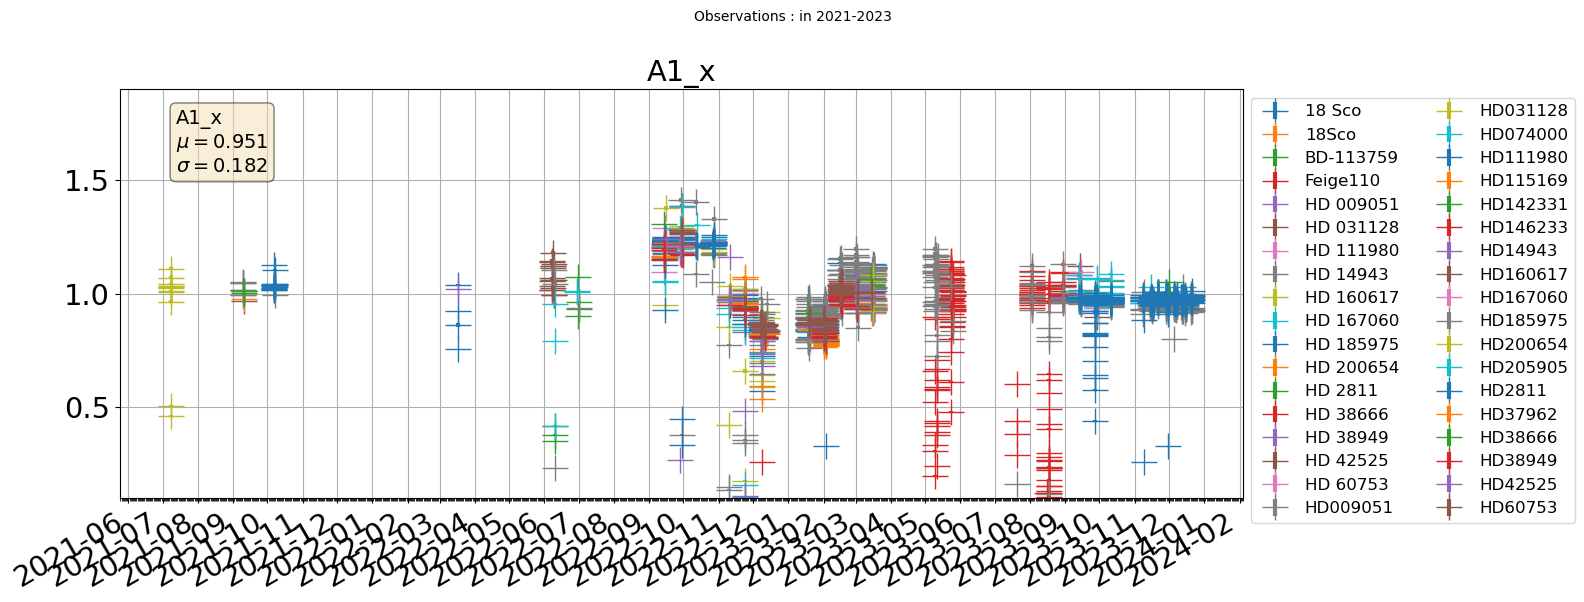

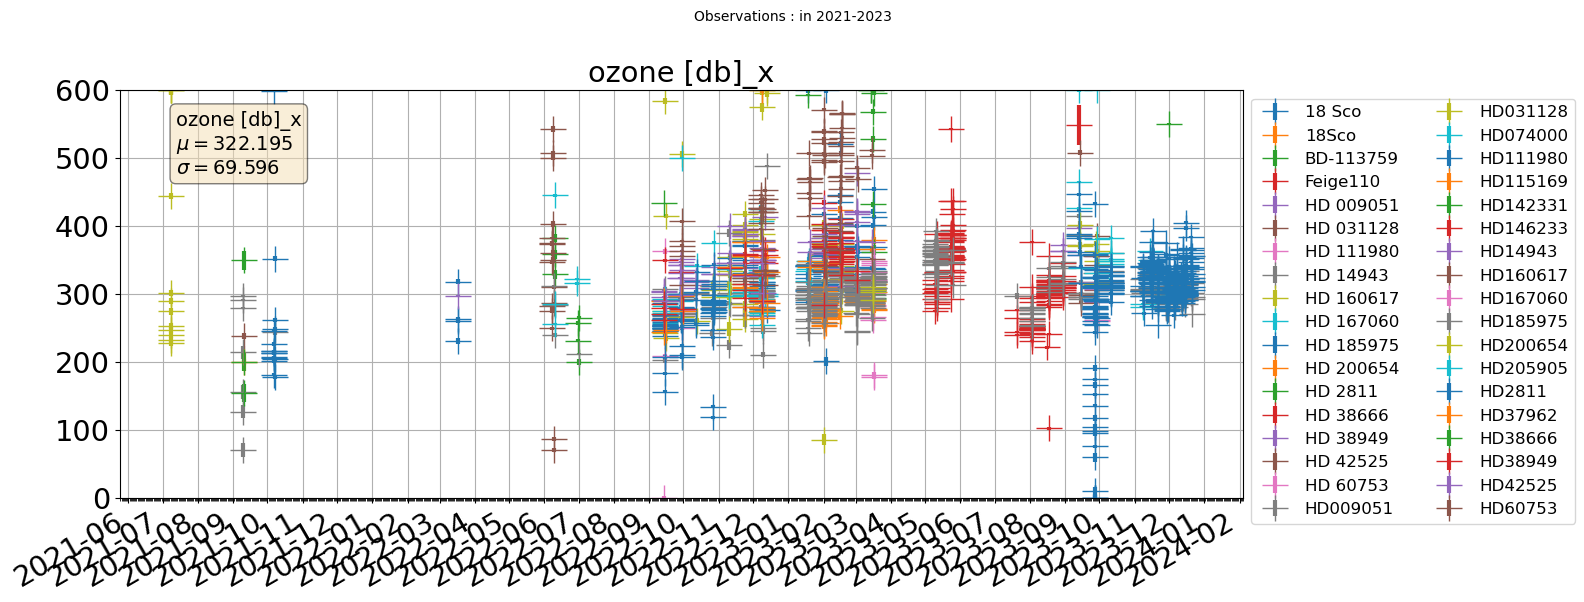

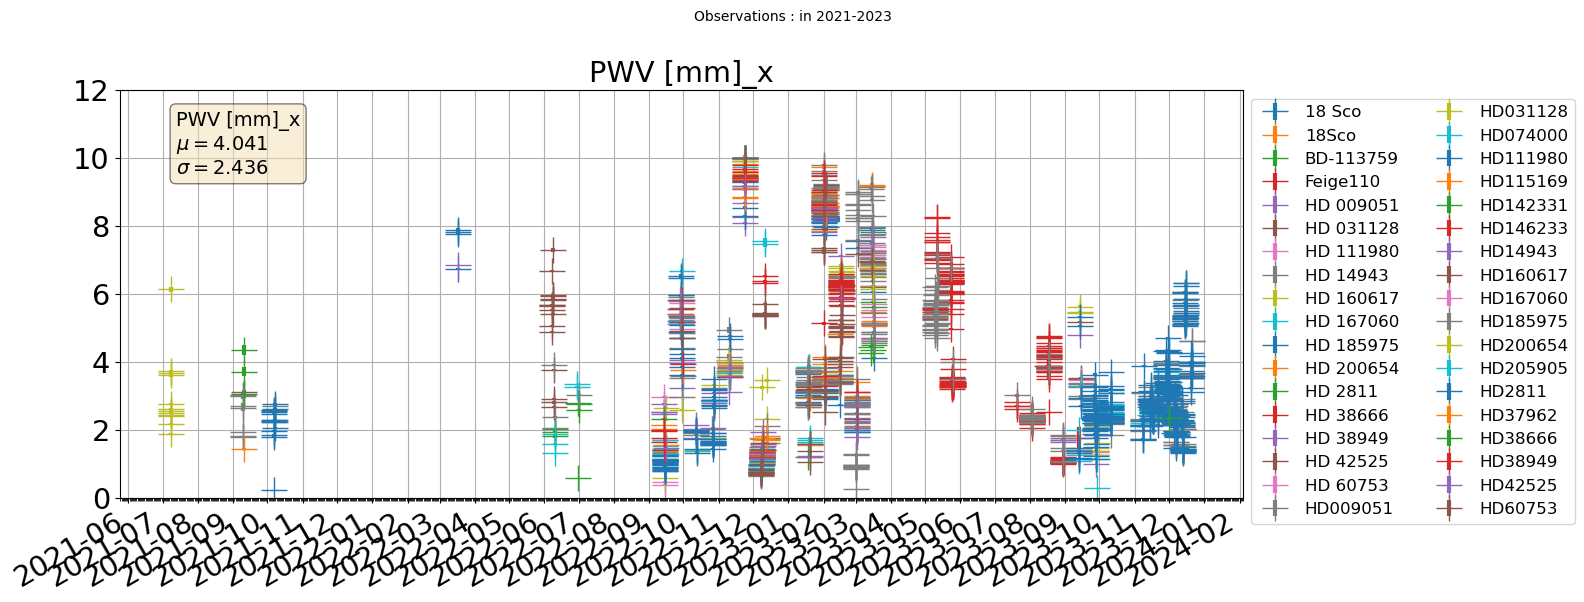

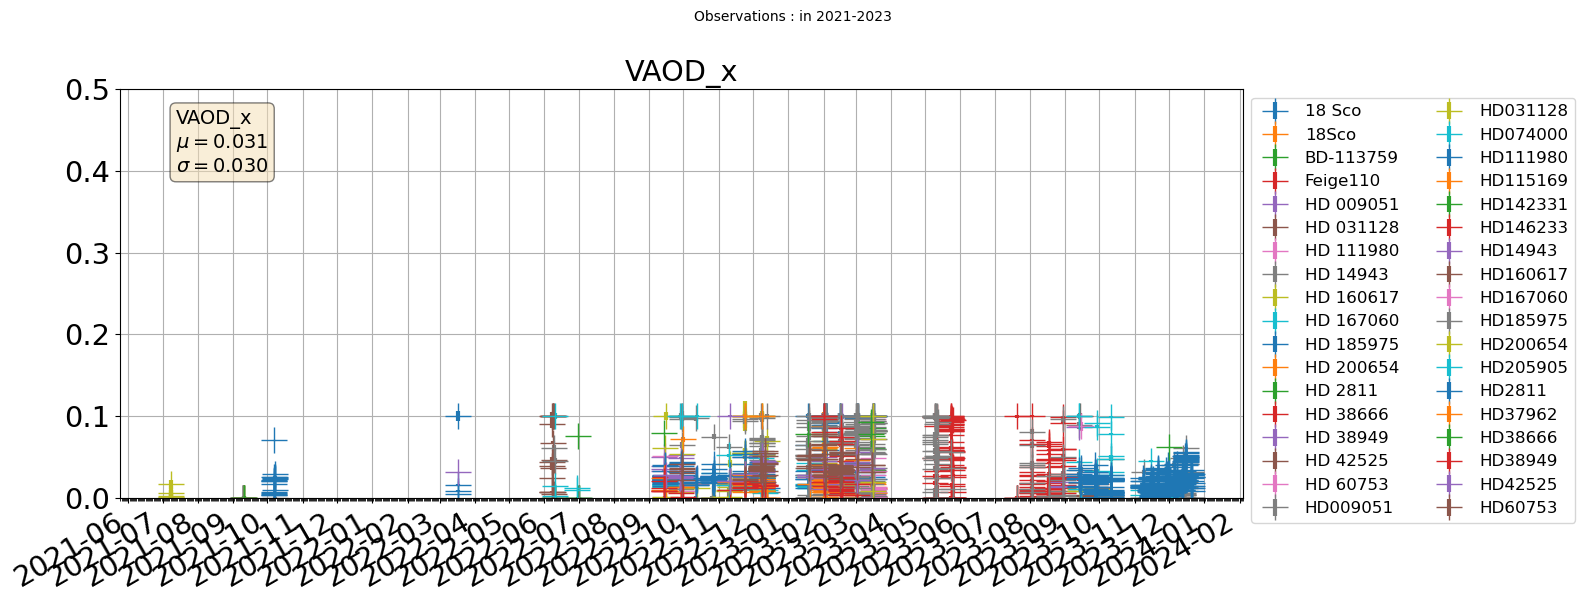

In [15]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

## Merra2

    MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv
    MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv
    MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv

In [16]:
top_merra2 = "../../../Merra2"

In [17]:
asm_merra2 = ["MERRA2_2021_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2022_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv",
              "MERRA2_2023_inst1_2d_asm_Nx_M2I1NXASM_lsst_AllYear.csv"]
Nasm = len(asm_merra2)

In [18]:
aer_merra2 = ["MERRA2_2021_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2022_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv",
              "MERRA2_2023_tavg1_2d_aer_Nx_M2T1NXAER_lsst_AllYear.csv"]
Naer = len(aer_merra2)

In [19]:
df_asm = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in asm_merra2] 
df_aer = [pd.read_csv(os.path.join(top_merra2,file),index_col=0) for file in aer_merra2] 

In [20]:
df_asm[0].head()

,PS,T10M,T2M,TO3,TOX,TQI,TQL,TQV,TS,U10M,U2M,U50M,V10M,V2M,V50M
time,,,,,,,,,,,,,,,
2021-01-01 00:00:00,78309.336,289.73587,289.72906,247.26114,0.005301,0.0,0.0,9.219856,289.53670,1.417040,1.029335,1.653588,1.271824,0.941790,1.593075
2021-01-01 01:00:00,78353.440,288.45830,288.14820,246.95404,0.005294,0.0,0.0,9.299347,287.69740,-0.640781,-0.321693,-0.997959,0.720388,0.370704,1.075519
2021-01-01 02:00:00,78399.140,289.09607,288.32602,246.62802,0.005287,0.0,0.0,9.733832,286.42050,-1.040606,-0.651973,-1.313788,0.071793,0.050780,0.098654
2021-01-01 03:00:00,78434.100,289.61584,288.91230,246.08704,0.005275,0.0,0.0,10.086275,285.64383,-0.592623,-0.392119,-0.690463,-0.301546,-0.178987,-0.397412
2021-01-01 04:00:00,78439.300,289.57867,288.79303,245.58127,0.005264,0.0,0.0,10.178970,284.94794,-0.186442,-0.133778,-0.234019,-0.381485,-0.213192,-0.497831


In [21]:
df_aer[0].head()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
time,,,
2021-01-01 00:30:00,1.196867,0.056970,0.053770
2021-01-01 01:30:00,1.198094,0.057817,0.054558
2021-01-01 02:30:00,1.201883,0.060025,0.056720
2021-01-01 03:30:00,1.209316,0.062329,0.059037
2021-01-01 04:30:00,1.218950,0.064500,0.061218


In [22]:
df_asm[0].index

Index(['2021-01-01 00:00:00', '2021-01-01 01:00:00', '2021-01-01 02:00:00',
       '2021-01-01 03:00:00', '2021-01-01 04:00:00', '2021-01-01 05:00:00',
       '2021-01-01 06:00:00', '2021-01-01 07:00:00', '2021-01-01 08:00:00',
       '2021-01-01 09:00:00',
       ...
       '2021-12-31 14:00:00', '2021-12-31 15:00:00', '2021-12-31 16:00:00',
       '2021-12-31 17:00:00', '2021-12-31 18:00:00', '2021-12-31 19:00:00',
       '2021-12-31 20:00:00', '2021-12-31 21:00:00', '2021-12-31 22:00:00',
       '2021-12-31 23:00:00'],
      dtype='object', name='time', length=5832)

Text(0.5, 1.0, 'Merra2 Ozone')

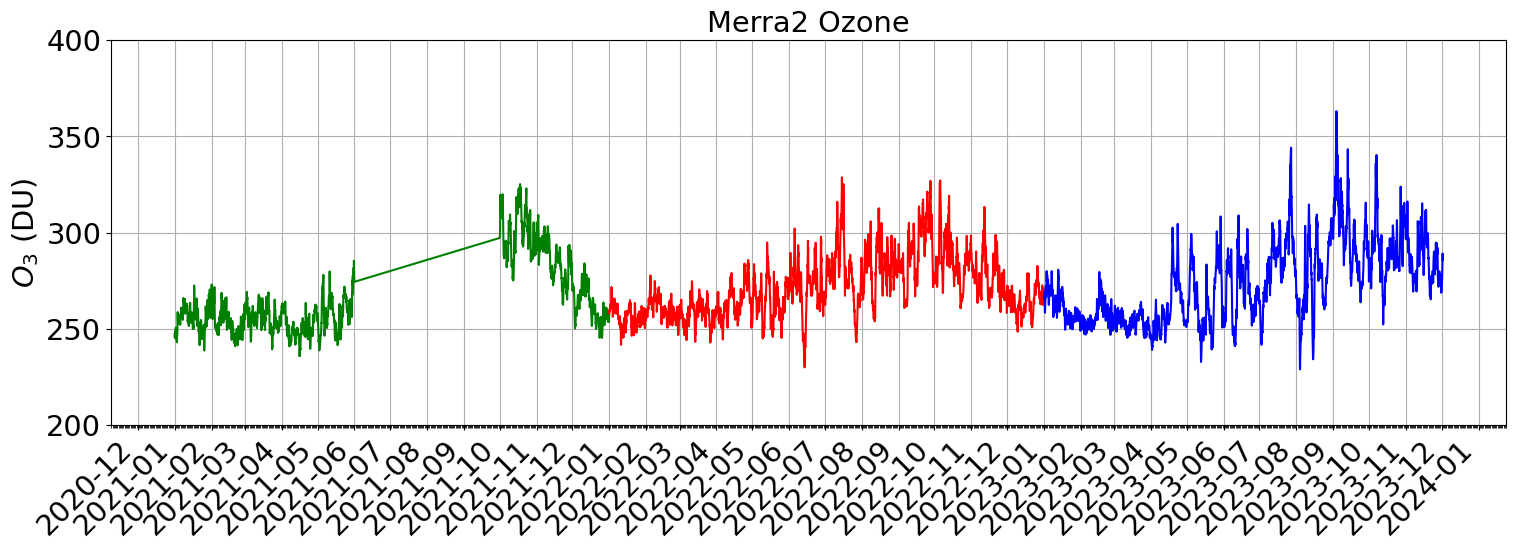

In [24]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'g-')
ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'r-')
ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');
ax.set_ylim(200.,400.)
ax.set_ylabel("$O_3$ (DU)")
ax.set_title("Merra2 Ozone")



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

for dateobs in df["dateobs"]:
    ax.axvline(dateobs,color="orange",lw=3,alpha=0.2)

ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'g-')
ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'r-')
ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,15.)
ax.set_ylabel("$PWV$ (mm)")
ax.set_title("Merra2 Precipitable Water Vapor")


Text(0.5, 1.0, 'Merra2 Aerosol Extinction')

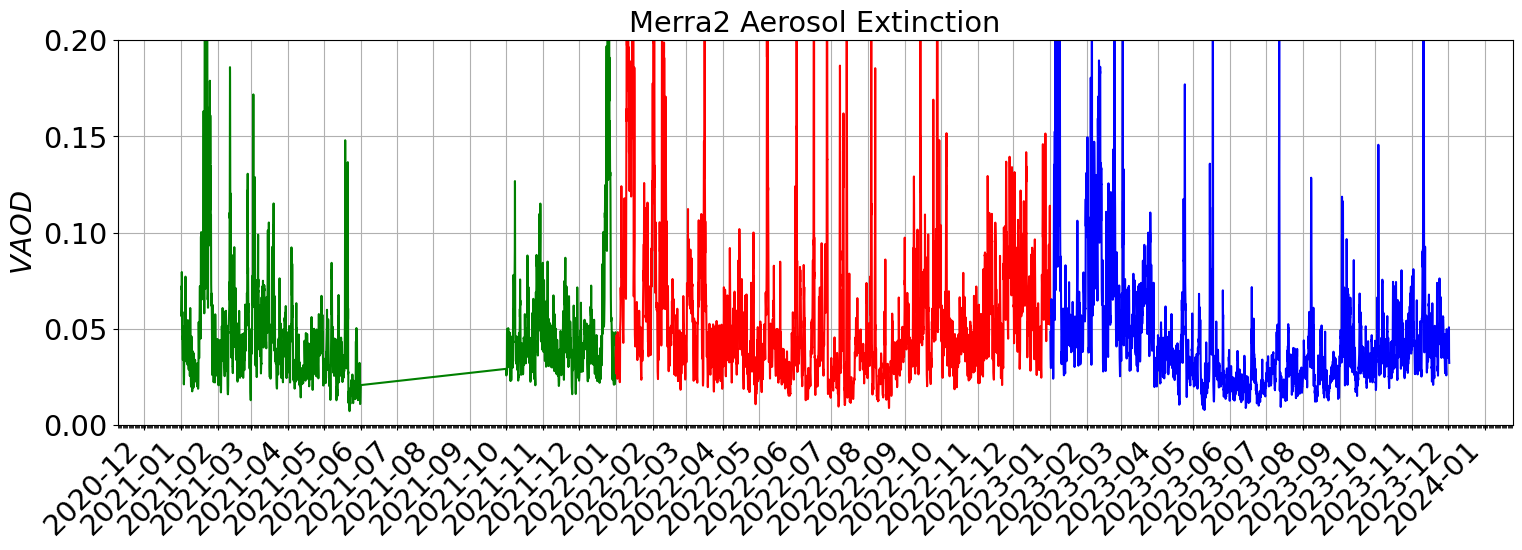

In [25]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTEXTTAU,'g-')
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTEXTTAU,'r-')
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTEXTTAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Extinction")

Text(0.5, 1.0, 'Merra2 Aerosol Scattering')

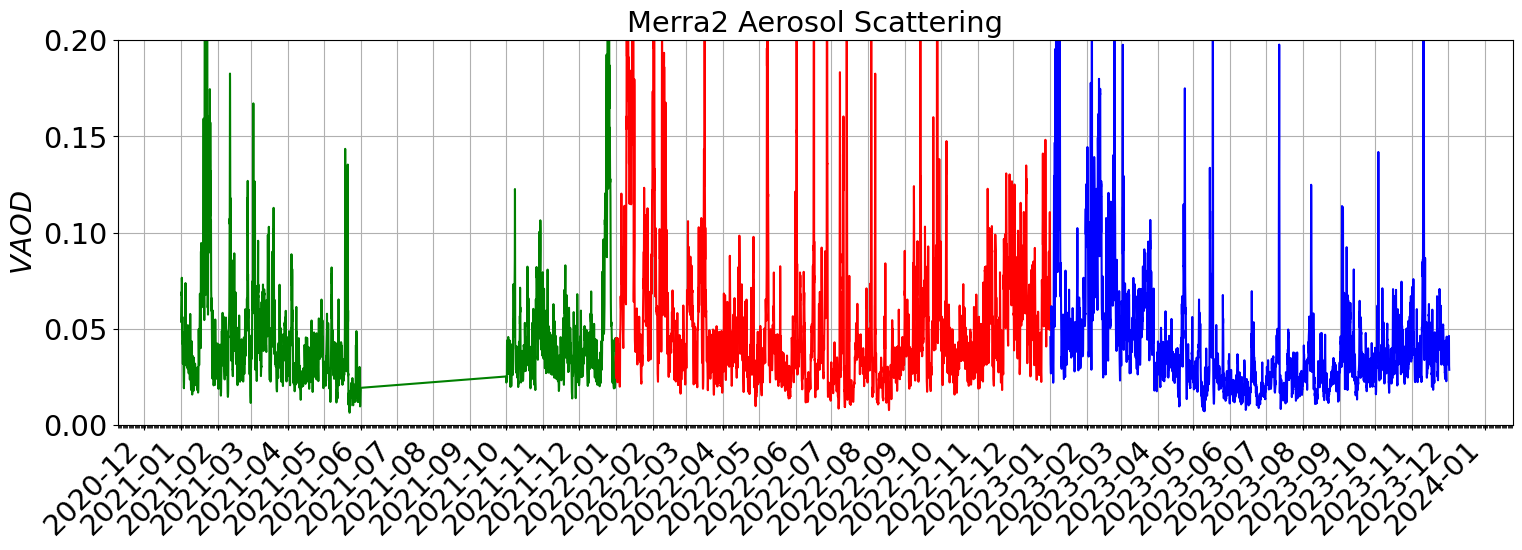

In [26]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 

    
ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTSCATAU,'g-')
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTSCATAU,'r-')
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTSCATAU,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

ax.set_ylim(0.,.2)
ax.set_ylabel("$VAOD$")
ax.set_title("Merra2 Aerosol Scattering")

Text(0.5, 1.0, 'Merra2 Aerosol exponent')

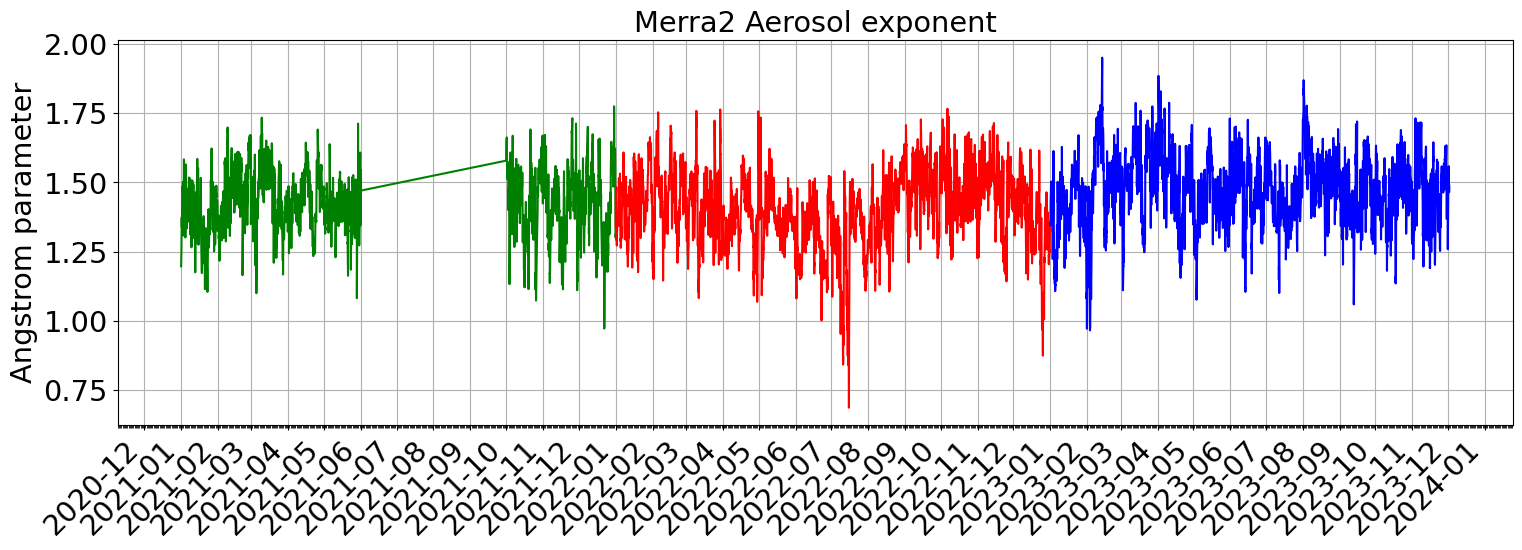

In [27]:
fig, ax = plt.subplots(1,1,figsize=(18, 5))

month_locator = mdates.MonthLocator(interval=1)
day_locator = mdates.DayLocator(interval=1)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


ax.plot(pd.to_datetime(df_aer[0].index),df_aer[0].TOTANGSTR,'g-')
ax.plot(pd.to_datetime(df_aer[1].index),df_aer[1].TOTANGSTR,'r-')
ax.plot(pd.to_datetime(df_aer[2].index),df_aer[2].TOTANGSTR,'b-')

ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
ax.xaxis.set_minor_locator(day_locator)
ax.xaxis.set_major_formatter(year_month_formatter)
ax.grid()
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right');

#ax.set_ylim(0.,2.)
ax.set_ylabel("Angstrom parameter")
ax.set_title("Merra2 Aerosol exponent")

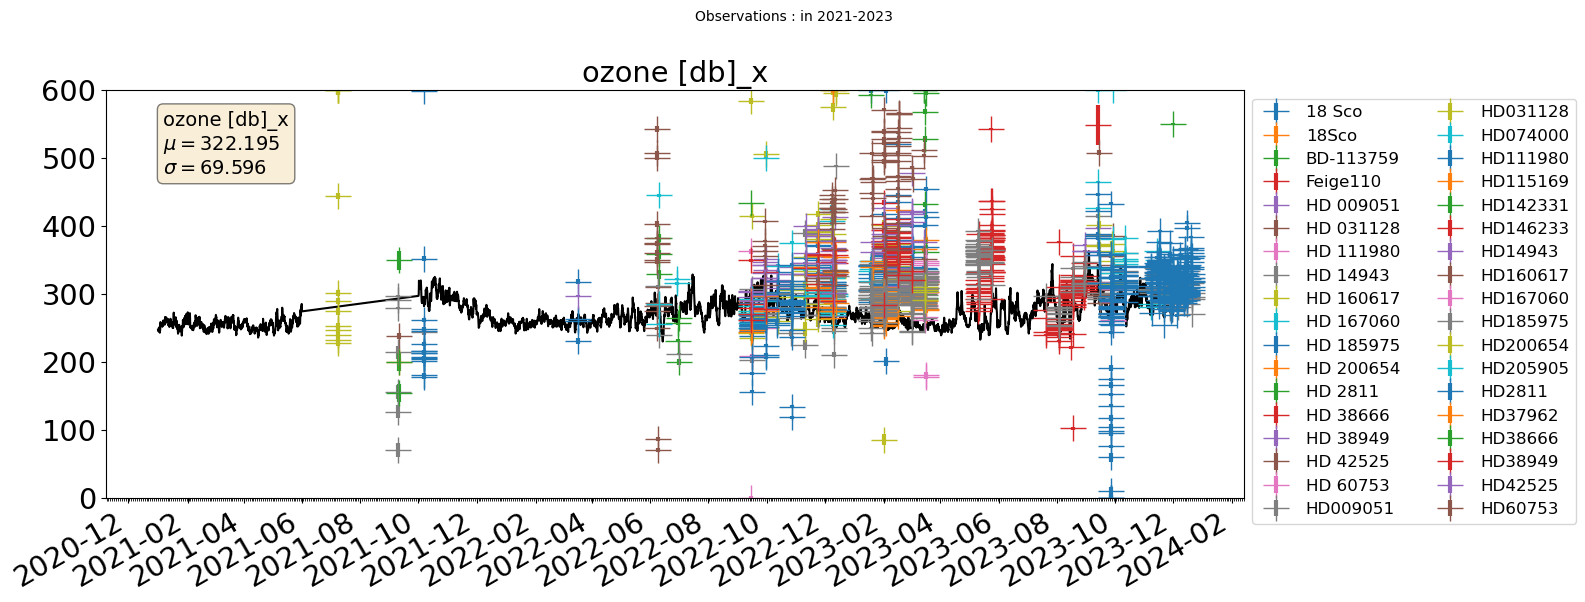

In [31]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["ozone [db]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TO3,'k-')
    ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TO3,'k-')
    ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TO3,'k-')
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()

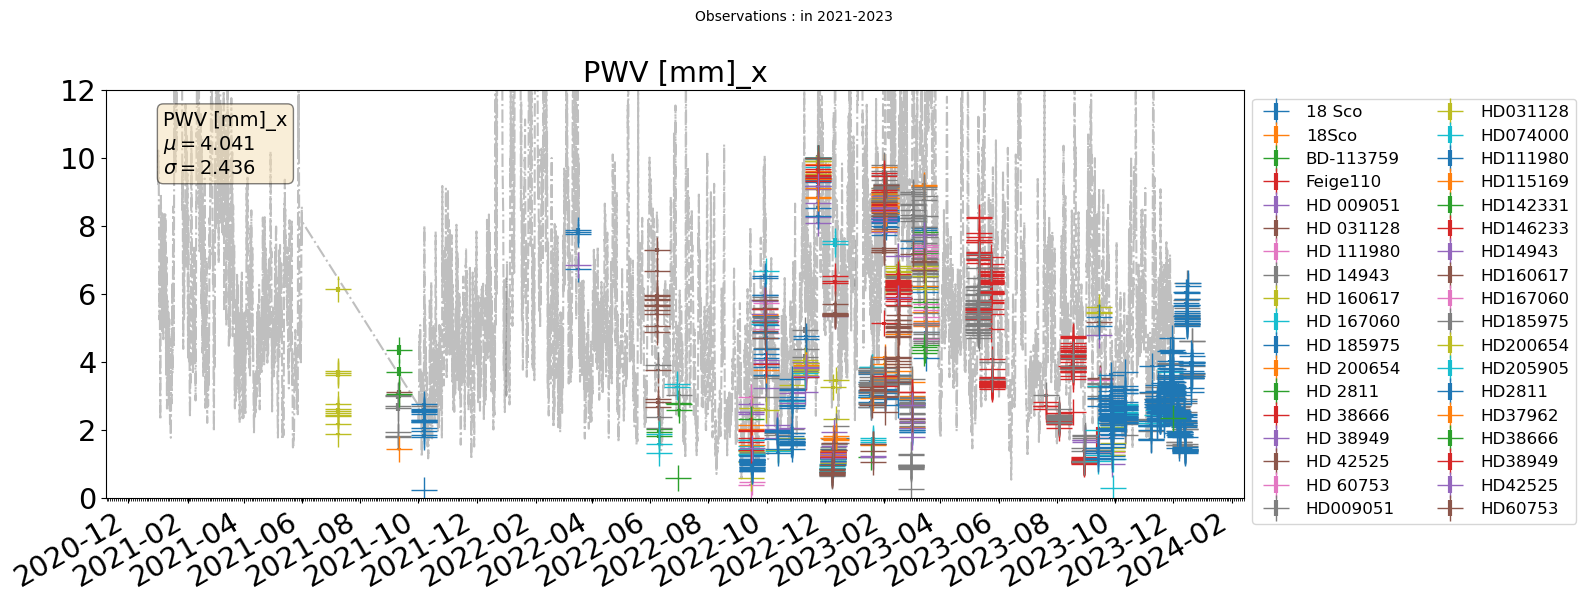

In [35]:
# Format for date
import matplotlib.dates as mdates
month_locator = mdates.MonthLocator(interval=2)
day_locator = mdates.DayLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") 


#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
for col in ["PWV [mm]_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(16,6))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(pd.to_datetime(rec["DATE-OBS"][index]), rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()

    ax.xaxis.set_major_locator(month_locator) # Locator for major axis only.
    ax.xaxis.set_minor_locator(day_locator)
    ax.xaxis.set_major_formatter(year_month_formatter)
    #fig.autofmt_xdate() # rotation
    
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    ax.plot(pd.to_datetime(df_asm[0].index),df_asm[0].TQV,'-.',color="grey",alpha=0.5)
    ax.plot(pd.to_datetime(df_asm[1].index),df_asm[1].TQV,'-.',color="grey",alpha=0.5)
    ax.plot(pd.to_datetime(df_asm[2].index),df_asm[2].TQV,'-.',color="grey",alpha=0.5)
    
    #plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left",ncols=2)
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : in 2021-2023"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()